# Person - EDA and Forecasting

This Notebook is the basis for forecasting object counts given a date and hour. It contains 3 sections:

- **Data preparation**. Here we will compose the dataset and describe the features.
- **Data exploration**. In this section we will start reviewing individual features.
- **Predicting object counts**. Here we will focus on generating an hourly forecast for a given day based on the selected attributes. The aim is to find the most useful model for this task.

In [504]:
# import ConfigImports Notebook to import and configure libs
%run ../Config/ConfigImports.ipynb

## Data preparation

The raw data extracted from the images is at the object level. Here are a few sample observations:

In [505]:
df = pd.read_csv('../Datasets/UniqueObjectDetections__person__2019-09-09_2020-03-02.csv')
print(df.shape)
df.head(2)

(4790, 26)


,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min,dummy_var,time_diff,sec_diff,x_center,y_center,prev_x_center,prev_y_center,euc_distance
0,73740,person,0.45050,459,24,478,38,2019-09-09,07.03.03,07.03.03.965_4d9909b4_person-car-car-car.jpg,2,965,2019-09-09 07:03:03.965,Monday,False,9,7,3,1,0 days 00:42:40.471000000,2560.47100,468.50000,31.00000,490.00000,310.00000,279.82718
1,73135,person,0.65872,286,238,381,340,2019-09-09,07.29.50,07.29.50.440_4e0ee29d_person-car-car.jpg,1,440,2019-09-09 07:29:50.440,Monday,False,9,7,29,1,0 days 00:26:46.475000000,1606.47500,333.50000,289.00000,468.50000,31.00000,291.18551


Analysis below will be performed at the daily / hourly level.

I have tried several other approaches (from 15-minute to 3-hour time intervals), but 15 minute intervals are definitely too random and 3 hours reduces the dataset size dramatically. Based on that it seems like hourly analysis (and later forecasting) is a good trade off.

To roll up the data to daily / hourly level we can use Pandas. This is straight forward.

The only issue I have identified with this approach is that it will only include date / hour combinations with observations. But in order to analyse data, gaps without any observations need to be filled with 0's. This is done in the `resampling` code snippet below.

In [506]:
# make sure Pandas understands date time fields
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = pd.to_datetime(df['date'])

# use Pandas handy resample feature to fill in gaps with 0's
object_detections = df.set_index('date_time').resample('H')['dummy_var'].sum().reset_index()
object_detections.columns = ['date_time', 'obs_count']
object_detections['date'] = object_detections['date_time'].dt.date.astype(str)
object_detections['hour'] = object_detections['date_time'].dt.hour
object_detections = object_detections[['date', 'hour', 'obs_count']]
object_detections.head(2)

,date,hour,obs_count
0,2019-09-09,7,2
1,2019-09-09,8,3


Now we will strip the dates with the server or power outage

In [507]:
# remove any entries where we know that there was an error in measurements
orig_size = object_detections.shape[0]
idx = object_detections['date'].isin(CONFIG['DOWNTIME_DATES'])
object_detections = object_detections.loc[~idx]
print(f'Removed {orig_size - object_detections.shape[0]} records')

Removed 72 records


Now we can add some useful features based on the date column:

In [508]:
# add date-time related features
object_detections['date'] = pd.to_datetime(object_detections['date'])
object_detections['n_month'] = object_detections['date'].dt.month
object_detections['n_week_in_month'] = (object_detections['date'].dt.day-1)//7+1
object_detections['day_of_week'] = object_detections['date'].dt.dayofweek
object_detections['day_of_week_name'] = object_detections['date'].dt.day_name()
object_detections['is_weekend_day'] = ((object_detections['date'].dt.dayofweek) // 5 == 1).astype(int)
object_detections['day_of_week_name_short'] = 'WeekDay'
idx = object_detections['day_of_week_name'].isin(['Saturday', 'Sunday'])
object_detections.loc[idx, 'day_of_week_name_short'] = object_detections[idx]['day_of_week_name']
object_detections.head(2)

,date,hour,obs_count,n_month,n_week_in_month,day_of_week,day_of_week_name,is_weekend_day,day_of_week_name_short
0,2019-09-09,7,2,9,2,0,Monday,0,WeekDay
1,2019-09-09,8,3,9,2,0,Monday,0,WeekDay


In [509]:
# save snapshot of data
object_detections.to_parquet('../Datasets/snapshots/object_counts.parquet', index=False)

Next, we can load the Dark Sky weather data extracted from Dark Sky API in the other Notebook.

The idea here is that features from this dataset might be useful to predict the count of observations in a given hour.

#### Warning!

We are bringing-in here the actual weather data.

We need to be careful here, as when system runs in *Production*, it will use the weather forecast (not actuals), which can be wrong.

This variability can be costly and needs special attention down the line.

In [510]:
# load weather data
weather = pd.read_csv('../Datasets/dark_sky_data_2019-09-09_2020-03-02.csv')
weather.head(2)

,ts,dt,cur__summary,cur__precipIntensity,cur__precipProbability,cur__precipType,cur__temperature,cur__apparentTemperature,cur__humidity,cur__windSpeed,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__summary,daily__sunriseTime,daily__sunsetTime,daily__temperatureHigh,daily__temperatureLow
0,1567985400,2019-09-09 00:30:00,Possible Light Rain,0.79290,0.47000,rain,14.06000,14.08000,0.96000,21.30000,35.13000,241,0.99000,0,10.79600,Possible drizzle in the morning.,1568008740,1568055900,16.60000,7.01000
1,1567989000,2019-09-09 01:30:00,Possible Light Rain,0.83100,0.45000,rain,13.99000,13.99000,0.93000,22.49000,35.87000,215,0.96000,0,10.94500,Possible drizzle in the morning.,1568008740,1568055900,16.60000,7.01000


Next, we can extend the weather data slightly and a few more date/time related features, which will allow us to join the 2 dataframes together in the next step.

In [511]:
# add date-time related features, so we can merge the datasets together
weather['dt'] = pd.to_datetime(weather['dt'])
weather['date'] = weather['dt'].dt.date
weather['date'] = pd.to_datetime(weather['date'])
weather['hour'] = weather['dt'].dt.hour
check_cols = ['dt', 'date', 'hour']
weather[check_cols].head(2)

,dt,date,hour
0,2019-09-09 00:30:00,2019-09-09,0
1,2019-09-09 01:30:00,2019-09-09,1


Now we can merge the 2 data sources and verify that all none of the observations was dropped

In [512]:
# join detections and weather data
merged = object_detections.merge(weather, on=['date', 'hour'])

# make sure that we have not lost any observations
assert object_detections.shape[0] == merged.shape[0]

In [513]:
# create a snapshot of merged dataset
merged.to_parquet('../Datasets/snapshots/object_counts_weather.parquet', index=False)

## Data exploration

Here we will the current shape of the data, all features along with their data types and we will verify if we have any missing data to deal with.

In [514]:
print(f'We have {merged.shape[0]} records with {merged.shape[1]} features')

We have 4140 records with 29 features


In [515]:
nulls = merged.isnull().sum().reset_index()
null_count = nulls[nulls[0] > 0].shape[0]
print (f'We have {null_count} missing values')

We have 0 missing values


Based on the information above, we don't have any missing data. This is good as dealing with missing data is always troublesome and both: removing the rows and imputing the values are never a perfect solution.

In [516]:
# print data types for each of the columns
# print(merged.dtypes)

To keep this Notebook clean I am not printing a summary for the datatypes of all the features, but here is the summary:
- 2 date/time columns
- 5 character-based columns
- 11 integer columns
- 11 floating point columns

Now lets plot the histograms for the selected numerical features and explore their distributions

In [517]:
# select features to inspect
inspect_cols = [
    ['cur__precipIntensity', 'cur__precipProbability', 'cur__temperature', 'cur__apparentTemperature'],
    ['cur__humidity', 'cur__windSpeed', 'cur__windGust', 'cur__windBearing'],
    ['cur__cloudCover', 'cur__uvIndex', 'cur__visibility', 'daily__temperatureHigh']
]
inspect_cols_flat = np.array(inspect_cols).flatten().tolist()

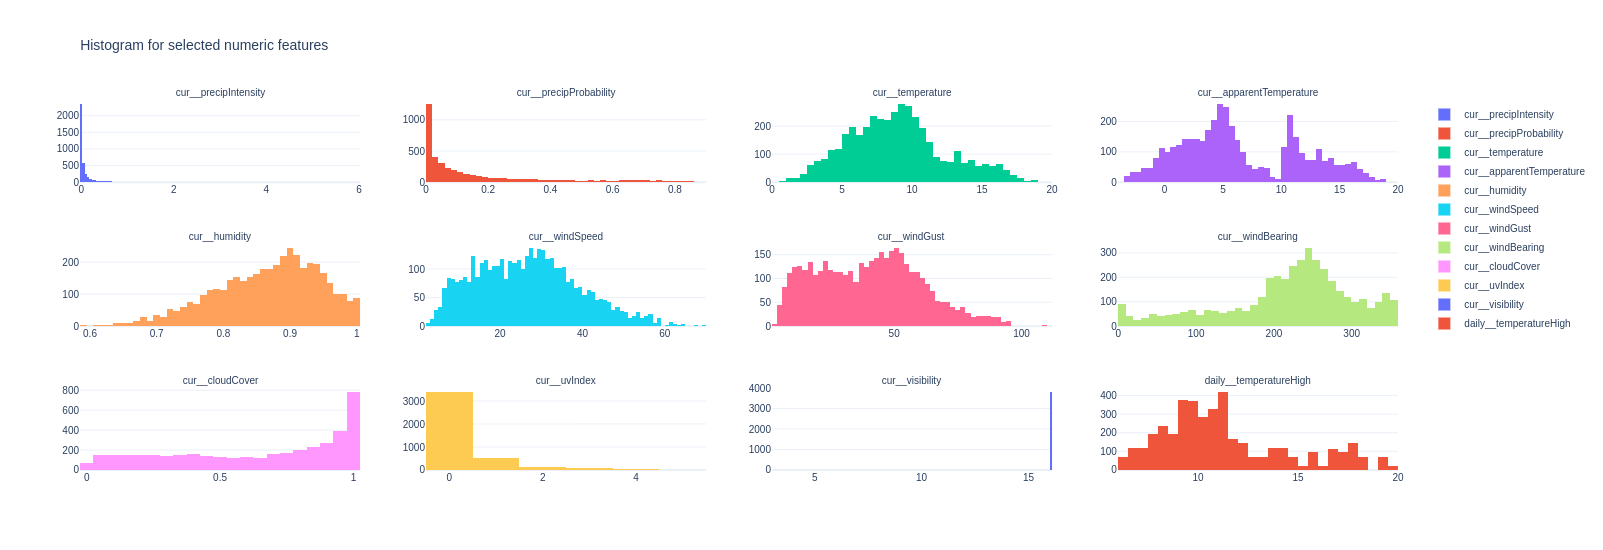

In [518]:
# draw a subplot with a histogram for each feature
fig = make_subplots(rows=len(inspect_cols), cols=len(inspect_cols[0]),
                    subplot_titles=tuple(inspect_cols_flat))
for i, col_set in enumerate(inspect_cols):
    for j, c in enumerate(col_set):
        fig.add_trace(go.Histogram(x=merged[c], name=c), row=i+1, col=j+1)
fig.update_layout(height=550, title_text="Histogram for selected numeric features", font=dict(size=10))
for i in fig['layout']['annotations']: i['font'] = dict(size=10)  # change subplot titles size
fig.show()

As we can see, the distibutions vary a lot.

We have some nice almost Gaussian distribution for the `temperature`, `humidity` and `wind`, and we have other distibutions, which follow a very different trends, like `precipitation`, `cloud-cover`, `uv-index` and `visibility`.

If we wanted to use a Linear Model to predict the counts from these features, it would not be able to use more than half of them and we would need to transform the data using one of the known methods:
- square root
- natural logarithm
- reciprocal transformation

Since I will be using a more complex/not linear model below, I will not be transforming the data at all and even when transformations were applied, they did not improve the accuracy of prediction models.

## Target variable

What about the values, which we are trying to predict?

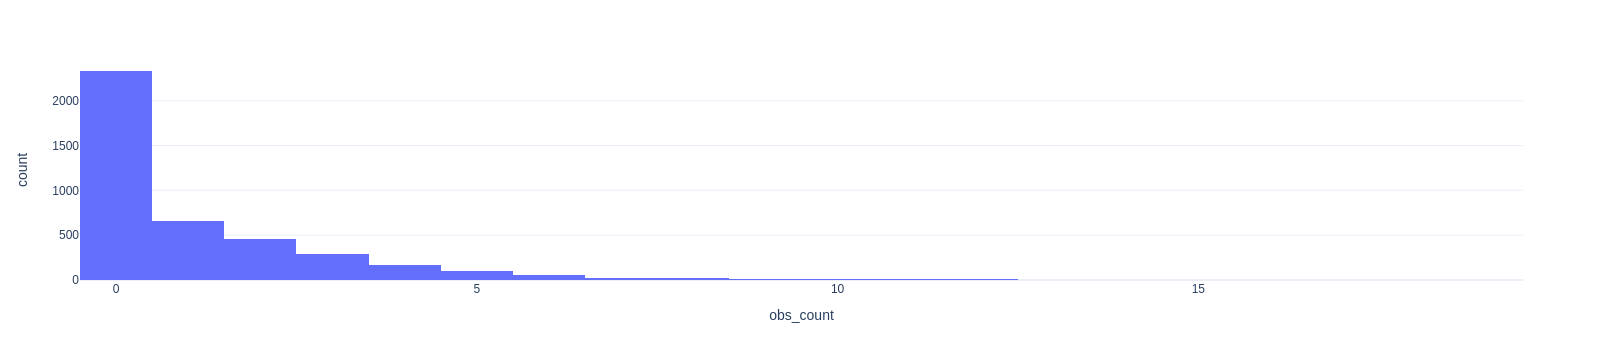

In [519]:
px.histogram(merged, x='obs_count', nbins=int(merged['obs_count'].max()) + 1,
             height=250, width=650)

The plot above seems to indicate that the data is skewed toward zero's.

The dataset has a lot of variability, as the same plot will look definitely different for 1AM and for 1PM. The nightly hours will be dominated by zeros, while during the day we will usually see 1 or 2 objects:

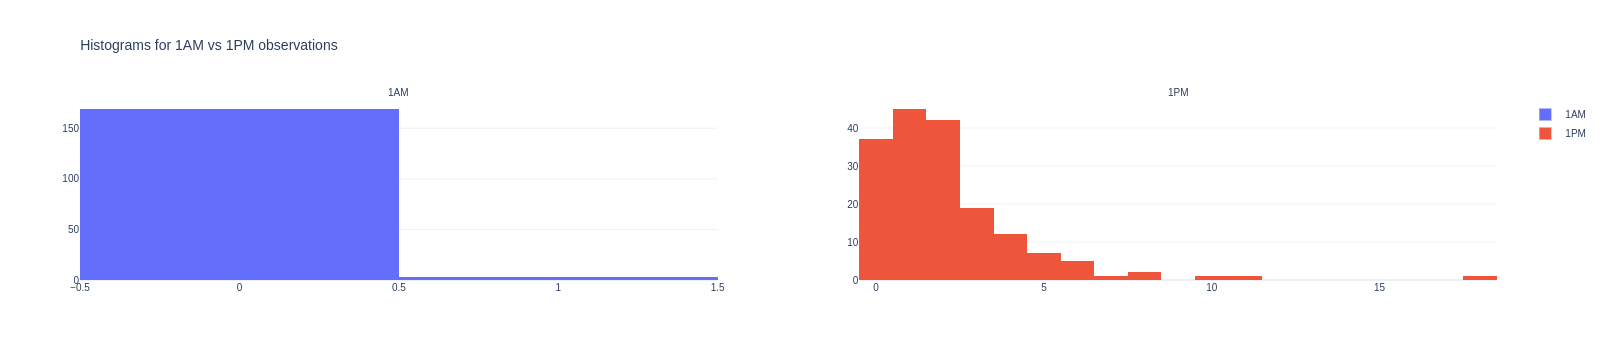

In [520]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('1AM', '1PM'))

fig.add_trace(go.Histogram(x=merged[merged['hour'] == 1]['obs_count'], name='1AM'), row=1, col=1)
fig.add_trace(go.Histogram(x=merged[merged['hour'] == 13]['obs_count'], name='1PM'), row=1, col=2)

fig.update_layout(height=350, width=900, title_text="Histograms for 1AM vs 1PM observations", font=dict(size=10))
for i in fig['layout']['annotations']: i['font'] = dict(size=10)  # change subplot titles size
fig.show()

Then again, it will be different for 7AM week day and 7AM weekend day. It is expected that during the weekend people sleep in more, and during the week they walk the dogs, drive to work etc.

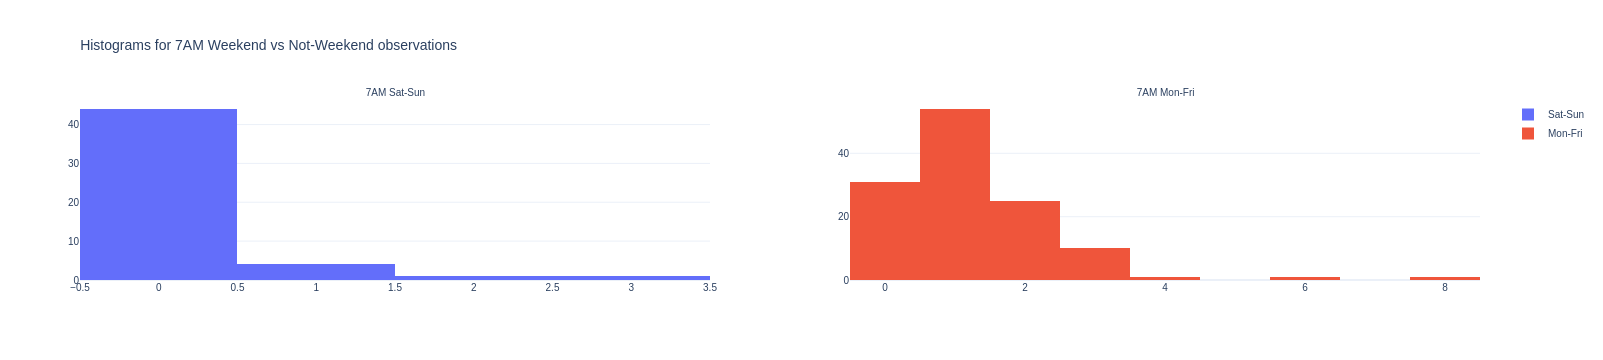

In [521]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('7AM Sat-Sun', '7AM Mon-Fri'))

filtered = merged[merged['hour'] == 7]

fig.add_trace(go.Histogram(x=filtered[filtered['is_weekend_day'] == 1]['obs_count'], name='Sat-Sun'), row=1, col=1)
fig.add_trace(go.Histogram(x=filtered[filtered['is_weekend_day'] == 0]['obs_count'], name='Mon-Fri'), row=1, col=2)

fig.update_layout(height=350, width=900, title_text="Histograms for 7AM Weekend vs Not-Weekend observations", font=dict(size=10))
for i in fig['layout']['annotations']: i['font'] = dict(size=10)  # change subplot titles size
fig.show()

What about the weather impact?

We can see in the plots for 2PM below that if the weather is bad, there is 32% probability of not seeing any object, where it's only 15% when the weather is good.

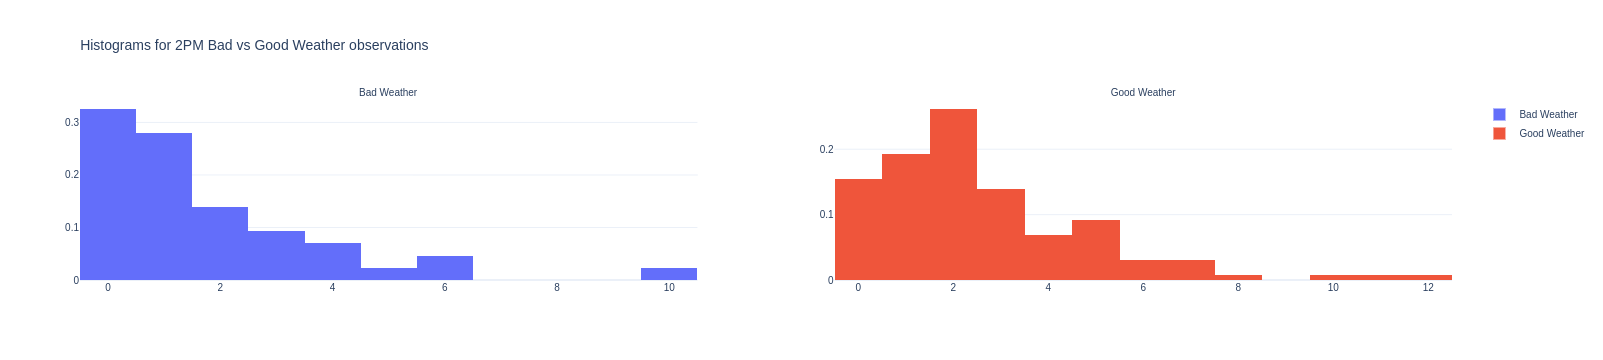

In [522]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Bad Weather', 'Good Weather'))

filtered = merged[merged['hour'] == 14]

bad_weather_words = ['drizzle', 'rain', 'danger']
bad_idx = merged['cur__summary'].str.contains("|".join(bad_weather_words), case=False)

bad_weather = filtered.loc[bad_idx]
good_weather = filtered.loc[~bad_idx]

fig.add_trace(go.Histogram(x=bad_weather['obs_count'], histnorm='probability', name='Bad Weather'), row=1, col=1)
fig.add_trace(go.Histogram(x=good_weather['obs_count'], histnorm='probability', name='Good Weather'), row=1, col=2)

fig.update_layout(height=350, width=900, title_text="Histograms for 2PM Bad vs Good Weather observations", font=dict(size=10))
for i in fig['layout']['annotations']: i['font'] = dict(size=10)  # change subplot titles size
fig.show()

Based on the vizualisations above we can conclude that there is definitely a difference between distributions at different hours of the day.

But what is also interesting is that perhaps, to generate a forecast for the count of observations, additional features can be also utilised and therefore Machine Learning solution could help here.

## Predicting observation counts

It is very useful to generate future predictions for the counts to expect in a full day ahead of time.

Based on this prediction we can inform the user about the situation to expect for the day, and if there is much more objects versus expected counts, we can trigger alerts and potentially prevent an unwanted incident.

My approach to predicting the observation counts for each date and hour is as follows:
- create a simple model without any Machine Learning techniques
- use feature selection techniques to see which features should be included in the ML model
- train a basic Machine Learning model and calculate error rate
- try to incorporate hand-engineered features and see if we can increase the model accuracy
- conclude with the method to use going forward

### Naive model

If we group the dataset by hour and calculate a mean of object counts - then we can convert that mean to the nearest integer and this is the most basic form of a forecast.

$$forecast(X_h)=roundInt(\frac{1}{n}\sum_{i=1}^{n}x_i)$$

Where $X_h$ is the training dataset containing all observations for a given hour $h$, and $n$ is a number of observations in that training set.

Benefits of this type of a basic forecast:
- easy to understand and explain
- fast to compute, requires low resources
- works for each object class without tweaking

Downsides of this forecast:
- it does not take into account any other factors (like weather type or day of week)
- it's skewed by outliers
- it does not provide the uncertainty about the results

#### Implementation:
- split dataset into training and test stes
- calculate means for each hour
- round means to nearest integer
- calculate errors against the test-set (with cross validation):
    - mean absolute error
    - mean squared error
    - r2 score (coefficient of determination)

Error calculations:

$$meanAbsoluteError=\frac{1}{n}\sum_{i=1}^{n}|true-predicted|$$
$$meanSquaredError=\frac{1}{n}\sum_{i=1}^{n}(true-predicted)^2$$
$$rSquared=1-\frac{SS_{res}}{SS_{tot}}$$

Where $SS_{res}$ is the sum of squares of residuals and $SS_{tot}$ is the total sum of squares [(source)](https://en.wikipedia.org/wiki/Coefficient_of_determination)

Below is a code snippet, which runs a 5-fold cross validation to calculate mean errors across all the folds.

In [524]:
# use features to create the forecast
X = merged[['hour', 'obs_count']]
y = merged['obs_count']

# KFold Cross Validation approach
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Iterate over each train-test split and calculate scores
mpds = [] 
mses = []
maes = []
r2s = []
acc = []
for train_index, test_index in tqdm(kf.split(X)):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # calculate hourly averages of counts for training set
    mean_obj_counts = X_train.groupby('hour')['obs_count'].mean()
    # now we can generate the predictions for the test set
    y_pred = X_test['hour'].map(mean_obj_counts)
    # round results
    y_pred_rounded = np.array([int(round(p)) for p in y_pred])
    # Calculate scores
    mpds.append(mean_poisson_deviance(y_test, y_pred + 0.00001))  # need to add a small quantity for Poisson deviance
    mses.append(mean_squared_error(y_test, y_pred))
    maes.append(mean_absolute_error(y_test, y_pred))
    r2s.append(r2_score(y_test, y_pred))
    acc.append(accuracy_score(y_test, y_pred_rounded))
print('mean mpd:', np.mean(mpds))
print('mean mse:', np.mean(mses))
print('mean mae:', np.mean(maes))
print('mean r2:', np.mean(r2s))
print('mean acc:', np.mean(acc))


mean mpd: 1.4253444586601745
mean mse: 2.8056633408547396
mean mae: 0.9432115834015284
mean r2: 0.2652330749121566
mean acc: 0.48599033816425125


How these errors are distibuted for the last train/test split?

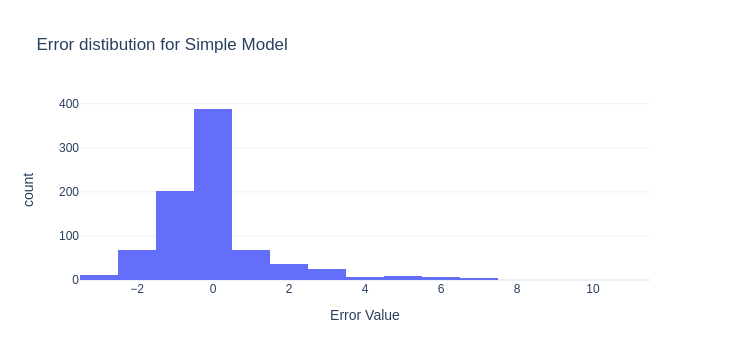

In [320]:
error = y_test - y_pred_rounded
px.histogram(x=error, height=300, width=600, labels={'x': 'Error Value'},
             title='Error distibution for Simple Model')

#### Conclusion:

The Simple model has perfectly predicted 388 observations out of 828.

Even though the Simple Model generated a somewhat dissapointing statistics, but can be still useful as it allows us to roughly predict how many observations are expected to occur in a given hour.

We can ask this model for an hour and it will give us the prediction:

In [316]:
hour = 16
pred = mean_obj_counts[hour]
print(f'Prediction for hour: {hour} is: {pred}, rounded to: {int(round(pred))} objects expected to see.')

Prediction for hour: 16 is: 2.993006993006993, rounded to: 3 objects expected to see.


In [317]:
hour = 4
pred = mean_obj_counts[hour]
print(f'Prediction for hour: {hour} is: {pred}, rounded to: {int(round(pred))} objects expected to see.')

Prediction for hour: 4 is: 0.0, rounded to: 0 objects expected to see.


In [318]:
hour = 6
pred = mean_obj_counts[hour]
print(f'Prediction for hour: {hour} is: {pred}, rounded to: {int(round(pred))} objects expected to see.')

Prediction for hour: 6 is: 0.6131386861313869, rounded to: 1 objects expected to see.


### Machine Learning strategy

Predicting object counts can be framed as a Supervised, Machine Learning problem. The historical counts are the labels, and other factors, like hour, day-of-week, temperature, precipitation are the input features.

#### Note on Neural Networks:

I have not chosen to use a Neural Network model for forecasting. Neural Networks are more suitable for larger datasets (we have only 4,140 records).

I have tested a standard Feed Forward Neural Network and an Recurrent Neural Network (bidirectional LSTM) sequence prediction model, but they both very quickly overfitted the data and they did not improve the results. They also took much longer to train, they were very sensitive to the parameter choice, and they do not generate the uncertainty about the predictions.

### Feature selection for Machine Learning

Before we apply Machine Learning to the problem, we should first select the features to use. Below are the 3 methods, which I have applied to achieve that:
- select K-Best using statistical test
- feature importances
- correlation matrix

#### K-Best features

Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

In [525]:
# import necessary libraries
from sklearn.feature_selection import SelectKBest, f_regression

# add a few extra features to the weather features
use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day'] + inspect_cols_flat
X = merged[use_cols]
y = merged['obs_count']

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=CONFIG['RANDOM_STATE'])

X_train.head()

,hour,n_month,day_of_week,is_weekend_day,cur__precipIntensity,cur__precipProbability,cur__temperature,cur__apparentTemperature,cur__humidity,cur__windSpeed,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__temperatureHigh
3949,20,2,5,1,0.28660,0.50000,7.85000,4.08000,0.91000,26.34000,48.56000,229,0.98000,0,16.09300,10.72000
3930,1,2,5,1,0.11480,0.23000,10.23000,10.50000,0.93000,53.70000,84.42000,239,0.99000,0,16.09300,10.72000
178,17,9,0,0,0.04580,0.04000,17.52000,17.59000,0.87000,11.21000,16.24000,39,0.95000,1,16.09300,19.42000
668,3,10,0,0,1.38820,0.80000,14.40000,14.48000,0.99000,39.06000,63.65000,188,1.00000,0,8.23000,15.79000
3330,1,1,1,0,0.00000,0.00000,2.61000,-2.81000,0.84000,27.55000,39.48000,268,0.27000,0,16.09300,7.06000


In [526]:
# extract top 12 features
k_best = SelectKBest(f_regression, k=8)
best_features = k_best.fit_transform(X_train, y_train)

In [527]:
# calculate pearson corr. manually
from scipy.stats.stats import pearsonr
corrs = []
for column in X_train.columns:
    corr_tuple = pearsonr(X_train[column], y_train)
    corrs.append(corr_tuple[0])

In [528]:
# create a new dataframe with all statistics necessary to explain the decisions
results = {
    'feature': X_train.columns,
    'k_best_score': k_best.scores_,
    'p_value': k_best.pvalues_,
    'pearson_corr': corrs
}
pd.set_option('display.float_format', lambda x: '%.5f' % x)
results = pd.DataFrame(results).sort_values('p_value').reset_index(drop=True).head(15)
results

,feature,k_best_score,p_value,pearson_corr
0,cur__uvIndex,229.22047,0.00000,0.25449
1,cur__humidity,212.88404,0.00000,-0.24582
2,cur__temperature,105.03652,0.00000,0.17538
3,cur__apparentTemperature,93.34441,0.00000,0.16561
4,hour,66.06391,0.00000,0.13989
5,cur__precipProbability,18.47170,0.00002,-0.07450
6,daily__temperatureHigh,17.71600,0.00003,0.07296
7,cur__cloudCover,13.20470,0.00028,-0.06304
8,cur__precipIntensity,11.65363,0.00065,-0.05923
9,cur__visibility,10.74136,0.00106,0.05687


Plot a joint plot for the best feature:

In [529]:
# define a function to render a jointplot for 2 variables
# inside a dataframe, and add Person correlation as an
# annotation within the plot
# Note: j.annotate has been deprecated 2 years ago in Seaborn
# without an alternative way to accomplish this, so I have disabled
# warnings for the duration of this function
import warnings
def plot_join_plot(df, feature, target):
    j = sns.jointplot(feature, target, data = df, kind = 'reg')
    warnings.simplefilter('ignore')
    j.annotate(pearsonr)
    warnings.simplefilter('always')
    return plt.show()

In [530]:
# put back Y into the same dataframe
train_df = pd.concat([X_train, y_train], axis=1)

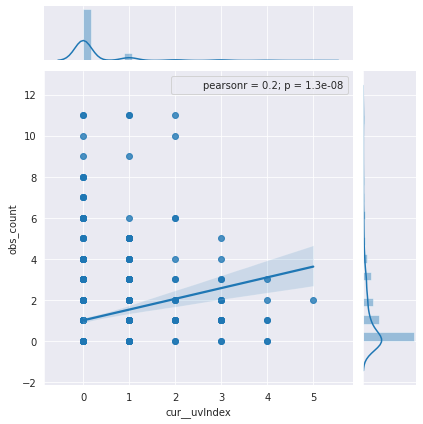

In [531]:
plot_join_plot(train_df[:800], "cur__uvIndex", 'obs_count')

#### Feature importance

You can get the feature importance of each feature of your dataset by using the feature importance property of the model.

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

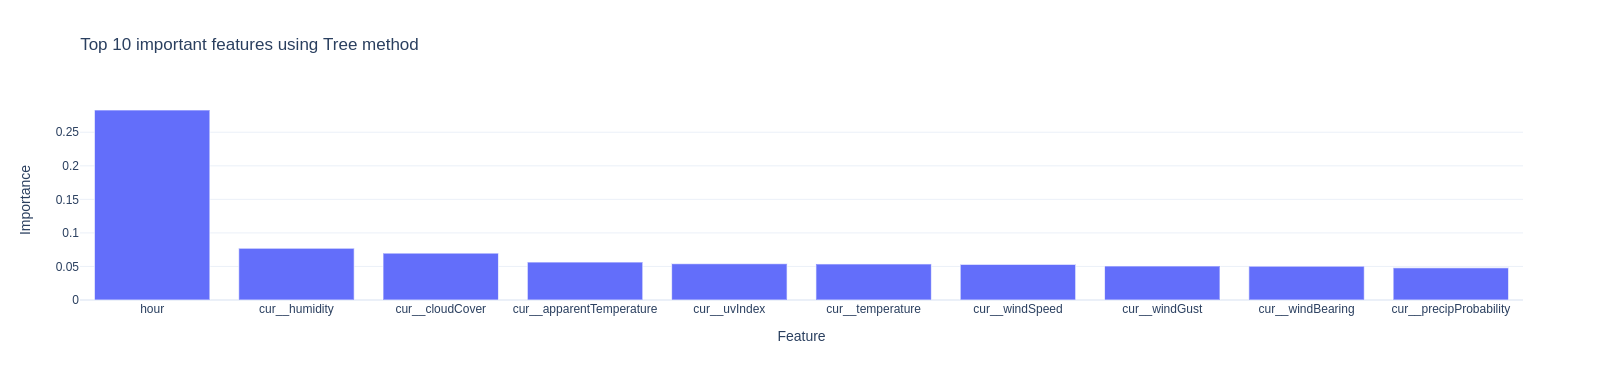

In [532]:
# import necessary libraries
from sklearn.ensemble import ExtraTreesRegressor

# extract feature importances from the Regressor
model = ExtraTreesRegressor()
_ = model.fit(X_train, y_train)

# import features and importances into a dataframe
top10 = pd.DataFrame([dict(zip(X.columns, model.feature_importances_))]).T.reset_index().sort_values(0, ascending=False).head(10)
top10.columns = ['Feature', 'Importance']

# visualize feature importances
px.bar(top10, x='Feature', y='Importance', width=600, height=380, title='Top 10 important features using Tree method')

#### Correlation Matrix

Correlation states how the features are related to each other or the target variable.

Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable). If correlation is near zero, then this feature does not have a direct correlation with the target variable.

Below I will plot the correlations of the features with the `obs_count` target variable.

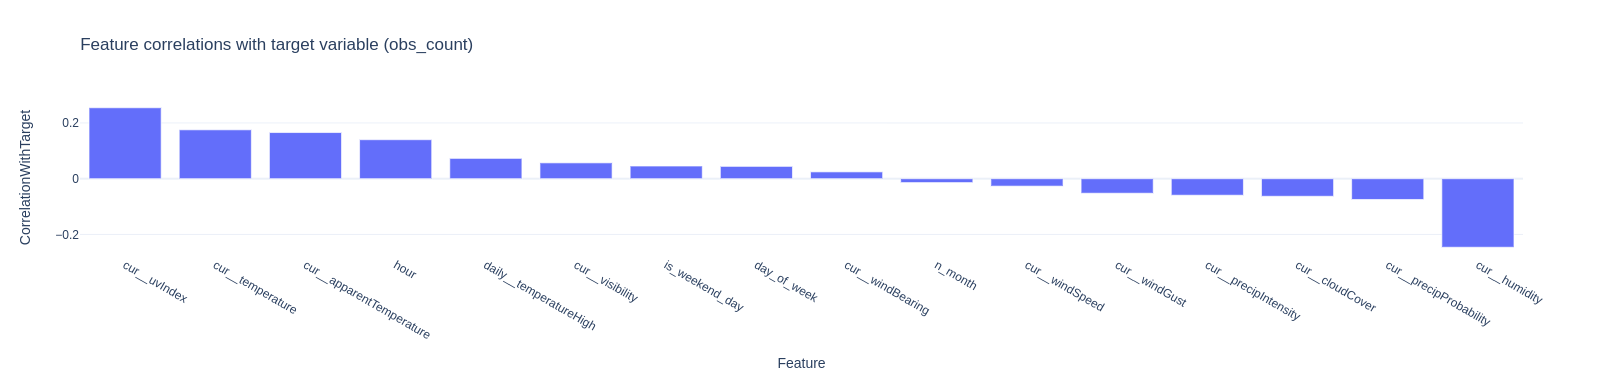

In [533]:
# get correlations between features in the dataset
corr_mat = train_df.corr()['obs_count'].reset_index().query('index != "obs_count"')
corr_mat.columns = ['Feature', 'CorrelationWithTarget']

# extract correlations and sort them
corrs = corr_mat.sort_values('CorrelationWithTarget', ascending=False)

# plot correlations with obs_count
px.bar(corrs, x='Feature', y='CorrelationWithTarget', width=800, height=380,
       title='Feature correlations with target variable (obs_count)')

We can also plot a correlation matrix of all the independent features to explore relationships between them (we can use excellent package `heatmap` for it):

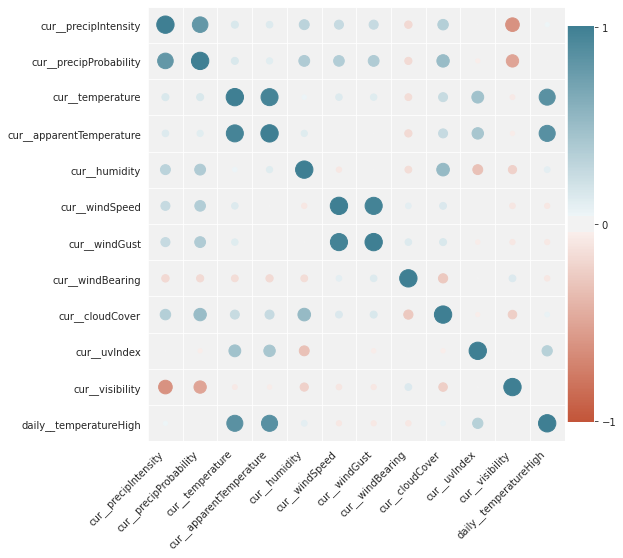

In [534]:
from heatmap import heatmap, corrplot
plt.figure(figsize=(8, 8))
corrplot(dataset[inspect_cols_flat].corr(), size_scale=300, marker='o');

### Decision Tree

Decison Trees are easy to interpret, no not require data scaling, and can be used for both: Data Analysis and Machine Learning.

Here is an example of a simple Decision Tree with maximum depth set to only $3$ levels and minimum samples required to split a node set to $7$. This is done for the readability and ilustrative purposes only, usually deeper trees are used.

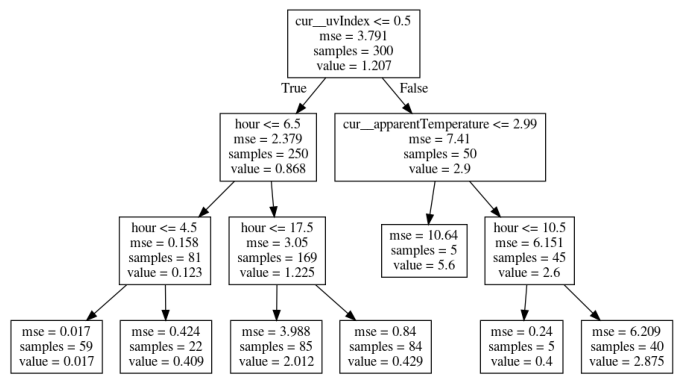

In [535]:
from sklearn import tree
from sklearn.tree import export_graphviz

use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day', 'cur__precipIntensity',
    'cur__precipProbability', 'cur__apparentTemperature', 'cur__humidity', 'cur__windSpeed',
    'cur__uvIndex']
tree_dataset = merged[use_cols + ['obs_count']].sample(300, random_state=CONFIG['RANDOM_STATE'])

model = tree.DecisionTreeRegressor(random_state=CONFIG['RANDOM_STATE'], max_depth=3, min_samples_split=7)
model = model.fit(tree_dataset.drop(columns=['obs_count']), tree_dataset['obs_count'])

export_graphviz(model, '../Resources/img/tree.dot', feature_names=tree_dataset.drop(columns=['obs_count']).columns)
!dot -Tpng ../Resources/img/tree.dot -o ../Resources/img/tree.png

img = cv2.imread('../Resources/img/tree.png')
plt.figure(figsize = (12, 12))
plt.axis('off')
plt.imshow(img);

In [537]:
# add a few extra features to the weather features
X = merged[use_cols]
y = merged['obs_count']

# KFold Cross Validation approach
kf = KFold(n_splits=5, shuffle=True, random_state=CONFIG['RANDOM_STATE'])
# Iterate over each train-test split and calculate scores
mpds = []
mses = []
maes = []
r2s = []
acc = []
for train_index, test_index in tqdm(kf.split(X)):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Scale train and test sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Train model
    model = tree.DecisionTreeRegressor(random_state=CONFIG['RANDOM_STATE'],
                                       max_depth=5, min_samples_split=21)
    model.fit(X_train_scaled, y_train)
    # Make predictions and round them off
    y_pred = model.predict(X_test_scaled)
    y_pred_rounded = np.array([round(p) for p in y_pred])
    # Calculate scores
    mpds.append(mean_poisson_deviance(y_test, y_pred + 0.00001))
    mses.append(mean_squared_error(y_test, y_pred))
    maes.append(mean_absolute_error(y_test, y_pred))
    r2s.append(r2_score(y_test, y_pred))
    acc.append(accuracy_score(y_test, y_pred_rounded))
print('mean mpd:', np.mean(mpds))
print('mean mse:', np.mean(mses))
print('mean mae:', np.mean(maes))
print('mean r2:', np.mean(r2s))
print('mean acc:', np.mean(acc))


mean mpd: 1.3959898645362452
mean mse: 2.731477902050502
mean mae: 0.9223914344130675
mean r2: 0.28578878670727875
mean acc: 0.5263285024154589


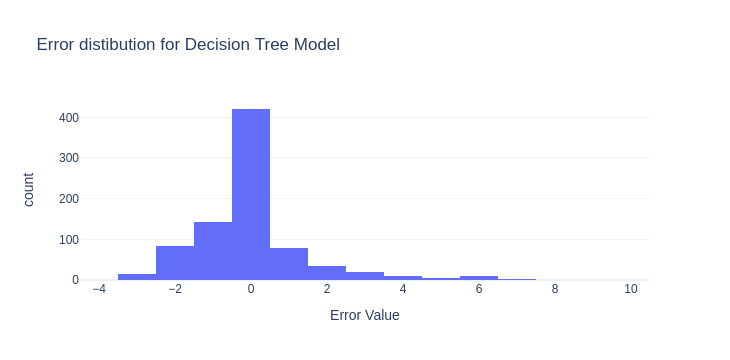

In [323]:
error = y_test - y_pred_rounded
px.histogram(x=error, height=300, width=600, labels={'x': 'Error Value'},
             title='Error distibution for Decision Tree Model')

### Gradient Boosting Regressor Tree

The next step is to extend a Decision Tree model from above with a more powerful one.

Below is a code snippet, which runs a 5-fold cross validation to calculate mean errors across all the folds for a Gradient Boosting Regressor model (best parameters have been estimated by running a `GridSearchCV` across 12,000 models).

In [538]:
warnings.simplefilter('ignore')
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
warnings.simplefilter('always')

In [539]:
# define features to use
use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day', 'cur__precipIntensity',
    'cur__precipProbability', 'cur__apparentTemperature', 'cur__humidity', 'cur__windSpeed',
    'cur__uvIndex']

# define x and y
X = merged[use_cols]
y = merged['obs_count']

# KFold Cross Validation approach
kf = KFold(n_splits=5, shuffle=True, random_state=CONFIG['RANDOM_STATE'])
# Iterate over each train-test split and calculate scores
mpds = []
mses = []
maes = []
r2s = []
acc = []
for train_index, test_index in tqdm(kf.split(X)):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Scale train and test sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Train model
    model = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.01, max_iter=550,
                                         max_bins=52, l2_regularization=0.1, random_state=CONFIG['RANDOM_STATE'],
                                         verbose=0, validation_fraction=0.1, n_iter_no_change=5,
                                         early_stopping=True)
    model.fit(X_train_scaled, y_train)
    # Make predictions and round them off
    y_pred = model.predict(X_test_scaled)
    y_pred_rounded = np.array([round(p) for p in y_pred])
    # Calculate scores
    mpds.append(mean_poisson_deviance(y_test, y_pred + 0.00001))
    mses.append(mean_squared_error(y_test, y_pred))
    maes.append(mean_absolute_error(y_test, y_pred))
    r2s.append(r2_score(y_test, y_pred))
    acc.append(accuracy_score(y_test, y_pred_rounded))
print('mean mpd:', np.mean(mpds))
print('mean mse:', np.mean(mses))
print('mean mae:', np.mean(maes))
print('mean r2:', np.mean(r2s))
print('mean acc:', np.mean(acc))


mean mpd: 1.2531104850796517
mean mse: 2.4693323870526007
mean mae: 0.8732665359758046
mean r2: 0.35505680609591905
mean acc: 0.5369565217391304


Gradient Boosting Regressor allows to look inside the model during the training phase and verify convergence.

This is achieved using the `train_score_` and `validation_score_` properties of the fitted estimator.

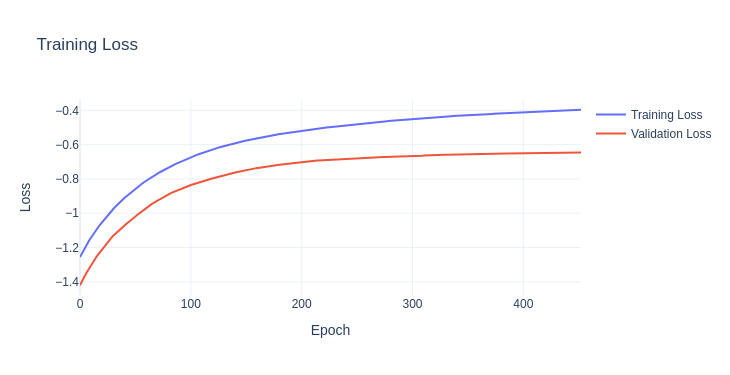

In [326]:
plt_loss(model.train_score_, model.validation_score_)

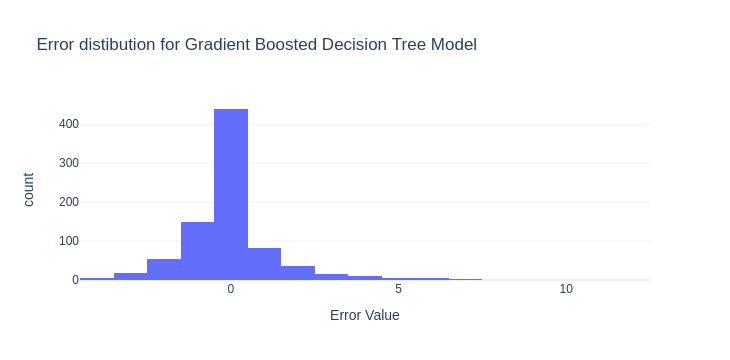

In [328]:
error = y_test - y_pred_rounded
px.histogram(x=error, height=300, width=600, labels={'x': 'Error Value'},
             title='Error distibution for Gradient Boosted Decision Tree Model')

And now we can take a look at the error distribution (for the last fold):

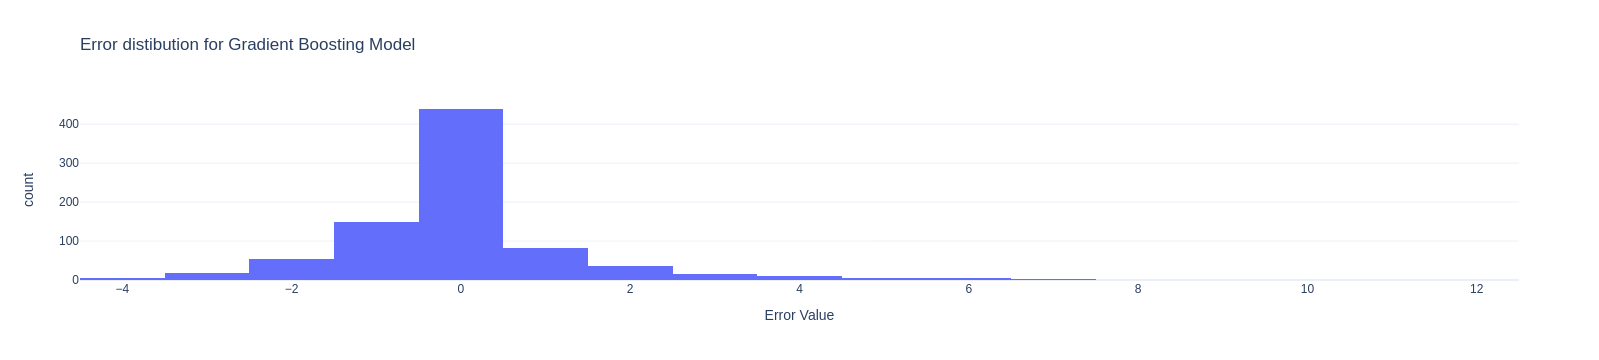

In [123]:
error = y_test - y_pred_rounded
px.histogram(x=error, height=300, width=600, title='Error distibution for Gradient Boosting Model',
             labels={'x': 'Error Value'})

The plot of residuals shows an even distribution of errors, which means that the model is not biased towards too low or too high values.

Number of correct predictions is in the middle and it is much larger than the errors.

We still have quite a lot of positive and negative errors, but they are expected in such a stochastic process with some expected errors in the measurements themselves.

### Gaussian Process

The last model in this Notebook is the Probabilistic Model.

Model below uses the RBF kernel as a prior, where model will optimise its `lengthscale` and `variance` parameters using sampling.

Poisson family function is used as a likelihood. Poisson is a special case of Binomial Distribution where number of tries goes to infinity.

I have switched the library from pymc3 to GPy, as pymc3 is consuming 20GB of RAM on Gaussian Processes even with a single feature.

In [331]:
import GPy

In [ ]:
%%time
# choose subset of features to improve speed and accuracy
use_feats = 'hour,cur__precipIntensity,cur__humidity,cur__apparentTemperature,cur__uvIndex,is_weekend_day'.split(',')

X = merged[use_feats]
y = merged['obs_count']

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=CONFIG['RANDOM_STATE'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_reshaped = np.expand_dims(y_train, axis=1)

# create kernel (tried adding periodic kernel Matern52 and it did not improve the performance)
# need to silence warnings due to deprecated function in GPy,
# seems like right now silencing is the recommended approach:
# https://github.com/sods/paramz/issues/17
warnings.simplefilter('ignore')
kernel_radial = GPy.kern.RBF(X_train_scaled.shape[1], ARD=True)

# create likelihood for the model and inference method
poisson_likelihood = GPy.likelihoods.Poisson()
laplace_inf = GPy.inference.latent_function_inference.Laplace()

# run Gaussian process and optimize parameters
m = GPy.core.GP(X=X_train_scaled, Y=y_train_reshaped, likelihood=poisson_likelihood,
                inference_method=laplace_inf, kernel=kernel_radial)
m.optimize()
warnings.simplefilter('always')

Out of all the models tested in this chapter, this is by far the longest one to train. It took over 18 minutes to run a single optimization cycle, which makes experimentations with different models quite challenging.

Due to this - I have not used the cross validation for this model, and I leave this part for the future experiments.

I have also chosen a limited number of features, I found that just a handful of features actually improved the results.

In GPy one can get a view of optimized kernel parameters by using the `kern` property from the optimized model:

In [598]:
#check the estimated parameters
m.kern

rbf.,value,constraints,priors
variance,2.9468130317534005,+ve,
lengthscale,"(5,)",+ve,


The next step is to generate predictions.

In [599]:
# scale test input data
X_test_scaled = scaler.transform(X_test[use_feats])

In [600]:
# predict directly the mean function
mean_functions, covariance = m.predict_noiseless(Xnew=X_test_scaled, full_cov=True)  

In [601]:
# verify shape of means and covariance
print(mean_functions.shape, covariance.shape)

(828, 1) (828, 828)


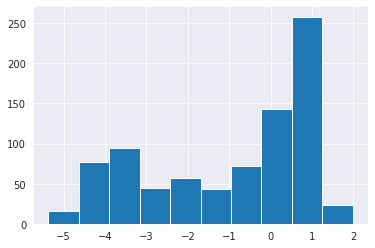

In [602]:
# this is the mean function of the GP
plt.hist(mean_functions);

In [603]:
# sampling from the posterior
n_samples = 500
sampled_functions = np.random.multivariate_normal(mean_functions[:,0], covariance, n_samples)

In [604]:
# the Poisson intensity is defined as exp(f)
exp_sampled_functions = np.exp(sampled_functions)

In [605]:
mean_intensity = np.mean(exp_sampled_functions, axis=0).reshape(-1, 1)  # calculate mean rates
mean_intensity.shape  # this is the mean intensity function estimated by the GP

(828, 1)

The mean intensity gives the mean rate of the Poisson distribution, the higher it is, the larger is the number of events for that relative row (X_test).

It is possible to take a sample prediction for the test data and draw probabilities for the counts between 0 and 20 for this mean rate.

The red point below represents the true value for this prediction.

Probabilities: [6.99108930e-01 2.50245141e-01 4.47874630e-02 5.34387156e-03
 4.78207986e-04]
Mean Rate: 0.35794871202965545


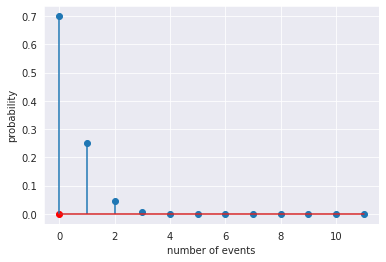

In [618]:
import scipy as sp
xx = np.arange(0, 12)
i = 50  # let's fix one test point
probabilities = sp.stats.poisson(mean_intensity[i]).pmf(xx)
print(f'Probabilities: {probabilities[:5]}')
plt.stem(xx, probabilities)
print(f'Mean Rate: {mean_intensity[i][0]}')
plt.ylabel('probability')
plt.xlabel('number of events')
plt.scatter(y_test.values[i], 0, color='r');  # true event

These probabilities are calculated using the following Poisson equation:

$$
p(X=K) = \frac{\lambda^K}{K!}e^{-\lambda}
$$

Below is a code sample to calculate a probability of $3$ counts for the mean rate above:

In [607]:
# verify scipy does the correct calculation:
search_count = 3
proba = mean_intensity[i] ** search_count / np.math.factorial(search_count) * np.exp(-mean_intensity[i])
proba

array([0.00534387])

Now metrics can be calculated for this model

In [620]:
mpd = mean_poisson_deviance(y_test.values, mean_intensity[:, 0])
mse = mean_squared_error(y_test.values, mean_intensity[:, 0])
mae = mean_absolute_error(y_test.values, mean_intensity[:, 0])
r2 = r2_score(y_test.values, mean_intensity[:, 0])
y_pred_rounded = np.array([round(p) for p in mean_intensity[:, 0]])
acc = accuracy_score(y_test.values, y_pred_rounded)

print('mean mpd:', mpd)
print('mean mse:', mse)
print('mean mae:', mae)
print('mean r2:', r2)
print('mean acc:', acc)

mean mpd: 1.2126075455662508
mean mse: 2.348202352964888
mean mae: 0.8658690211958526
mean r2: 0.33344072352913023
mean acc: 0.5060386473429952


#### Exploiting uncertainty in predictions

In [ ]:
# calculate standard deviation for each sample from the posterior
exp_sampled_functions_std = np.std(exp_sampled_functions,axis=0)

In [658]:
# what is the mean of uncertainty
np.mean(exp_sampled_functions_std)

0.20153681917226482

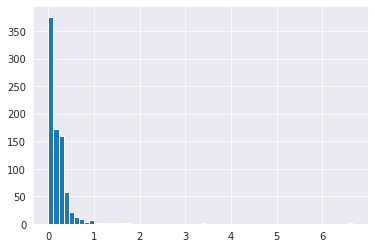

In [626]:
# plot frequency for the variance in predictions
plt.hist(exp_sampled_functions_std, bins=60);

Next, plotting instances with low and high uncertainty should highlight examples, which are easy and hard to predict

In [627]:
# sort instances with higher variance
sorted_indexes = np.argsort(exp_sampled_functions_std)

low uncertainty: 0.00443554573194984, index 308


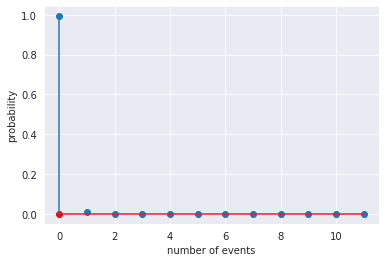

In [633]:
# plot an instance, which is easy to predict versus the true value
i = sorted_indexes[0]
print(f'low uncertainty: {exp_sampled_functions_std[i]}, index {i}')
plt.stem(xx,sp.stats.poisson(mean_intensity[i]).pmf(xx))
plt.ylabel('probability')
plt.xlabel('number of events')
plt.scatter(y_test.values[i],0,color='r') # true event
plt.show()

In [634]:
# explain why is it easy by showing a record from the test-set
X_test.iloc[i]

hour                       5.00000
cur__precipIntensity       0.15020
cur__apparentTemperature   5.02000
cur__uvIndex               0.00000
is_weekend_day             1.00000
Name: 3286, dtype: float64

high uncertainty: 3.406553195195788, index 57


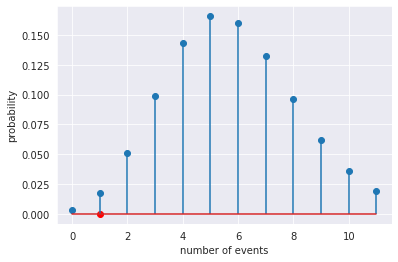

In [635]:
# plot an instance, which is hard to predict versus the true value
i = sorted_indexes[-2]
print(f'high uncertainty: {exp_sampled_functions_std[i]}, index {i}')
plt.stem(xx,sp.stats.poisson(mean_intensity[i]).pmf(xx))
plt.ylabel('probability')
plt.xlabel('number of events')
plt.scatter(y_test.values[i],0,color='r') # true event
plt.show()

In [636]:
# explain why is it hard by showing a record from the test-set
X_test.iloc[i]

hour                       15.00000
cur__precipIntensity        1.58200
cur__apparentTemperature    0.62000
cur__uvIndex                0.00000
is_weekend_day              1.00000
Name: 2312, dtype: float64

### Answering interesting questions

There are also a lot of interesting questions, which can be answered by knowing the mean rate $\lambda$. Below are two examples:
- What is the probability to see an object at time greater than $t$ given the rate $\lambda$?

In [639]:
predicted_rate = 1.89

In [647]:
mins = 48
t = mins / 60
p_t = np.exp(-predicted_rate * t)
p_t

0.22046859952901593

There is a $22\%$ chance that an object will show after $48$ minutes for a $lamda=1.89$.

- What is the probability to see an object at time less or equal $t$ given the rate $\lambda$?

In [648]:
mins = 12
t = mins / 60
p_t = 1 - np.exp(-predicted_rate * t)
p_t

0.3147694993341297

There is a $31\%$ chance that an object will show in the first $12$ minutes for a $lamda=1.89$.

With this kind of possibility, one could start thinking about a smart system, which can answer any questions of similar nature based on the generated predictions.

### Exploiting uncertainty

At last, the uncertanty can be exploited an many interesting ways as well.

The next section uses Poisson probability and uncertainty to generate a range of predictions instead of a single count.

Lets say that the mean rate is $2.49$. Given this, what is the expected number of objects within an hour?

In [651]:
mean_rate = 2.49
xx = range(0, 5)
probabilities = sp.stats.poisson(mean_rate).pmf(xx)
print(probabilities)
expected_count = np.argmax(probabilities)
print(expected_count)

[0.08290997 0.20644582 0.25702504 0.21333078 0.13279841]
2


Now we can exploit an uncertainty around this mean rate. Below are a three different scenarios with varying uncertanties: low, medium and high. I will add these uncertanties to the mean rate and this will create a range of possible counts.

In [680]:
def get_new_count(mean_rate, uncertainty=0):
    xx = range(0, 20)
    # calculate count using mean rate
    orig_probabilities = sp.stats.poisson(mean_rate).pmf(xx)
    orig_expected_count = np.argmax(orig_probabilities)
    
    # add uncertanty and calculate new count
    new_probabilities = sp.stats.poisson(mean_rate + uncertainty).pmf(xx)
    new_expected_count = np.argmax(new_probabilities)
    
    # generate a range of counts based on the differnce between
    # original count and new count (which includes uncertainty)
    count_diff= new_expected_count - orig_expected_count
    return [c for c in range(orig_expected_count - count_diff, orig_expected_count + count_diff + 1)]

In [681]:
low_uncertainty = 0.01
count = get_new_count(mean_rate, low_uncertainty)
print(count)

[2]


In [682]:
medium_uncertainty = 0.6
count = get_new_count(mean_rate, medium_uncertainty)
print(count)

[1, 2, 3]


In [683]:
high_uncertainty = 2.5
count = get_new_count(mean_rate, high_uncertainty)
print(count)

[0, 1, 2, 3, 4]


What if we try to recalculate models accuracy based on this logic?

In [689]:
orig_counts = np.array([get_new_count(c) for c in mean_intensity[:, 0]])

In [698]:
print(mean_squared_error(y_test.values, orig_counts[:, 0]))
print(mean_absolute_error(y_test.values, orig_counts[:, 0]))
print(r2_score(y_test.values, orig_counts[:, 0]))
print(accuracy_score(y_test.values, orig_counts[:, 0]))

2.4396135265700485
0.7801932367149759
0.30749280398008627
0.5591787439613527


In [712]:
new_counts = []
for i, c in enumerate(mean_intensity[:, 0]):
    new_counts.append(get_new_count(c, exp_sampled_functions_std[i]))

In [751]:
# how many ranges have been generated based on the uncertainty?
count_ranges = len([r for r in new_counts if len(r) > 1])
print(f'{count_ranges} ranges created, {round(count_ranges / len(new_counts), 2) * 100}% predictions')

130 ranges created, 16.0% predictions


In [742]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

new_counts_corrected = []
correction_rate = []
for i, c in enumerate(y_test.values):
    # calculate the value we are correcting predictions without uncertainty by
    if c != orig_counts[:, 0][i] and len(new_counts[i]) > 1:
        correction_rate.append(np.abs(c - orig_counts[:, 0][i]))
    # get value closest to the target here
    new_counts_corrected.append(find_nearest(new_counts[i], c))

In [743]:
# check how many values were 
print(len(correction_rate), np.mean(correction_rate))

92 1.934782608695652


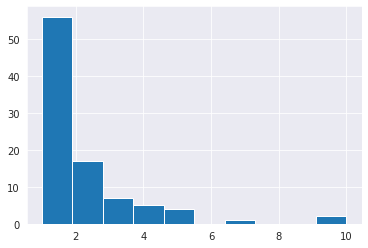

In [754]:
# plot corrections frequency
plt.hist(correction_rate, bins=10);

In [755]:
# how did this influence the metrics?
print(mean_squared_error(y_test.values, new_counts_corrected))
print(mean_absolute_error(y_test.values, new_counts_corrected))
print(r2_score(y_test.values, new_counts_corrected))
print(accuracy_score(y_test.values, new_counts_corrected))

2.0833333333333335
0.6582125603864735
0.4086262806265588
0.6292270531400966
